In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
data_ind = 2
camera_data_file = f"./gesture_data/gesture_data_{data_ind}.json"
phone_data_file = f"./gesture_data_phone/{data_ind}.csv"

# Camera data analysis

In [3]:
f = open(camera_data_file)
c_data = json.load(f)
p = []
  
for pose_id in c_data:
    p.append([pose_id, len(c_data[pose_id])])
  
# Closing file
f.close()

In [4]:
p = pd.DataFrame(p).sort_values(1, ascending=False)

In [5]:
p

,0,1
232,232,2231
247,247,2035
311,311,528
437,437,209
276,276,127
...,...,...
105,105,1
317,317,1
316,316,1
315,315,1


In [6]:
def get_data_for_ind(data, ind):
    processed_data = [] 
    for d in data[ind]:
        r = [int(d["time"]*1000)]
        for k in d["keypoints"]:
            r.append(k[0])
            r.append(k[1])
        processed_data.append(r)

    data = pd.DataFrame(processed_data)

    left_wrist_index = 7
    right_wrist_index = 4

    index_plot = right_wrist_index*2 + 1

    final_data = data[[0, index_plot]].loc[data[index_plot]!=-1].values

    final_data[:,0] = final_data[:, 0] - final_data[0,0]
    final_data = pd.DataFrame(final_data)

    rel = pd.DataFrame({0: list(range(0,int(final_data.iloc[-1][0]),10))})

    final_data  = rel.set_index(0, drop=True).join(final_data.set_index(0, drop=True), how="outer").interpolate()
    camera_data = final_data.values[:,0]
    camera_data = (camera_data - np.mean(camera_data))/np.std(camera_data)
    return camera_data

In [7]:
p1_data = get_data_for_ind(c_data, '232')

In [8]:
p2_data = get_data_for_ind(c_data, '247')

# phone data visualization

In [9]:
def get_phone_data(phone_data_file):
    data = pd.read_csv(phone_data_file, sep='\t')

    data[[0,1,2]] = data["data"].str.split(",", expand=True)
    for i in range(3):
        data[i] = data[i].astype(float)

    def get_magnitude(d):
        mag = np.sqrt(np.square(d.values).sum(axis=1))
        return mag

    data["mag"] = get_magnitude(data[[0,1,2]])

    accel_data = data[data["datatype"]=="accel"][["Timestamp", 0]].sort_values("Timestamp")

    accel_data["Timestamp"] = (accel_data["Timestamp"] - accel_data.iloc[0]["Timestamp"]).astype(int)

    rel = pd.DataFrame({"Timestamp": list(range(0,int(accel_data.iloc[-1]["Timestamp"]),10))})

    accel  = rel.set_index("Timestamp", drop=True).join(accel_data.set_index("Timestamp", drop=True), how="outer").interpolate()

    phone_data = accel.values[:,0]
    phone_data = (phone_data - np.mean(phone_data))/np.std(phone_data)
    return phone_data

In [10]:
phone_data = get_phone_data(phone_data_file)
camera_data = p1_data

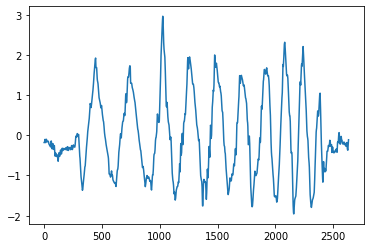

In [11]:
plt.plot(phone_data)

In [12]:
phone_data = phone_data[500:2300]

In [13]:
max_corr = 0.0
max_ind = 0
for ind in range(camera_data.size-phone_data.size+1):
    data_seg = camera_data[ind:ind+phone_data.size]
    corr_val = scipy.stats.spearmanr(data_seg, phone_data).correlation
    if corr_val > max_corr:
        max_corr = corr_val
        max_ind = ind

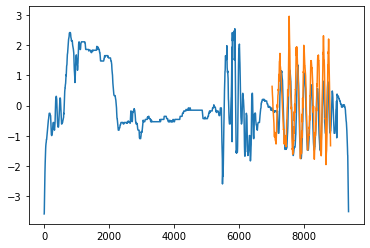

In [14]:
plt.plot(camera_data)
plt.plot(list(range(max_ind, max_ind+phone_data.size)), phone_data)

In [15]:
max_corr

0.7332146701655218